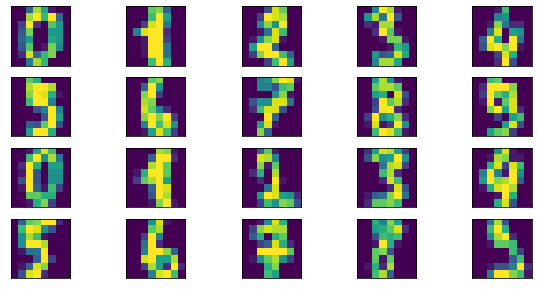

In [7]:
import tensorflow as tf
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import numpy as np

#load dataset and plot first 20 digits

digits = load_digits()

fig, axes = plt.subplots(4, 5, figsize=(10, 5),
                        subplot_kw={'xticks':(), 'yticks': ()})
for ax, img in zip(axes.ravel(), digits.images):
    ax.imshow(img)

In [8]:
#break data on train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    digits.data, digits.target,  random_state=42, shuffle=True)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
m, n = X_train.shape
print(X_train.shape)

(1347, 64)


In [9]:
#prepare log folder for tensoroard
from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

In [10]:

#hyperparameters
n_neurons = 100
n_neurons2 = 60
n_outputs = 10
learning_rate = 0.05
n_epochs = 500
batch = 50
# hyperparameters for batch_norm
eps = 0.01
gamma = 0.1
betta = 0.2

def fetch_batch(batch):
    index = np.random.randint(0, m, batch)
    X_batch = X_train[index]
    y_batch = y_train[index]
    return X_batch, y_batch

def batch_norm(X):
    mean = tf.reduce_mean(X, 0)
    G2 = tf.reduce_mean((X - mean)**2, 0)
    x_norm = (X - mean) / (tf.sqrt(G2 + eps))
    x_new = gamma * x_norm + betta
    return x_new

X = tf.placeholder(tf.float32, shape=(None, X_train.shape[1]), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

#first layer of the simple dnn
with tf.name_scope("first_layer"):
    init = np.random.randn(n, n_neurons) / np.sqrt(n / 2) #init for Relu
    W = tf.Variable(init, name="kernel", dtype=tf.float32)
    b = tf.Variable(tf.zeros([n_neurons]), name="bias", dtype=tf.float32)
    Z = tf.matmul(X, W) + b
    Z = tf.maximum(0.0, Z, name="activation") #Relu
    Z = batch_norm(Z) # batch norm
    
#second layers
with tf.name_scope("second_layer"):
    init = np.random.randn(n_neurons, n_neurons2) / np.sqrt(n_neurons / 2)
    W = tf.Variable(init, name="kernel", dtype=tf.float32)
    b = tf.Variable(tf.zeros([n_neurons2]), name="bias", dtype=tf.float32)
    Z = tf.matmul(Z, W) + b
    Z = tf.maximum(0.0, Z, name="activation")
    Z = batch_norm(Z) # batch norm
    
#last layer
with tf.name_scope("last_layer"):
    init = np.random.randn(n_neurons2, n_outputs) / np.sqrt(n_neurons2 / 2)
    W = tf.Variable(init, name="kernel", dtype=tf.float32)
    b = tf.Variable(tf.zeros([n_outputs]), name="bias", dtype=tf.float32)
    Z_out = tf.matmul(Z, W) + b
       
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=Z_out)
    loss = tf.reduce_mean(xentropy, name="loss")
    
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(Z_out, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
      
init = tf.global_variables_initializer()
saver = tf.train.Saver()

#prepare scalars for tensorboard
accuracy_summary = tf.summary.scalar('Accuracy', accuracy)
loss_summary = tf.summary.scalar('Loss', loss)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(m // batch):
            X_batch, y_batch = fetch_batch(batch)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        summary_str_accuracy = accuracy_summary.eval(feed_dict={X: X_batch, y: y_batch})
        file_writer.add_summary(summary_str_accuracy, epoch)
        summary_str_loss = loss_summary.eval(feed_dict={X: X_batch, y: y_batch})
        file_writer.add_summary(summary_str_loss, epoch)
        save_path = saver.save(sess, "./my_model_final.ckpt")

In [11]:

learning_rate = 0.01
n_epochs = 500

with tf.Session() as sess:
    saver.restore(sess, 
                  "./my_model_final.ckpt")
    for epoch in range(n_epochs):
        for iteration in range(m // batch):
            X_batch, y_batch = fetch_batch(batch)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        summary_str_accuracy = accuracy_summary.eval(feed_dict={X: X_batch, y: y_batch})
        file_writer.add_summary(summary_str_accuracy, epoch)
        summary_str_loss = loss_summary.eval(feed_dict={X: X_batch, y: y_batch})
        file_writer.add_summary(summary_str_loss, epoch)
        save_path = saver.save(sess, "./my_model_final.ckpt")

In [13]:
#predict on test images and evaluate accuracy
correct = tf.nn.in_top_k(Z, y_test, 1)
cast = tf.cast(correct, tf.float32)
accuracy = tf.reduce_mean(cast)

with tf.Session() as sess:
    saver.restore(sess, 
                  "./my_model_final.ckpt")
    Z = Z_out.eval(feed_dict={X: X_test})
    y_pred = np.argmax(Z, axis=1)
    accuracy = accuracy.eval(feed_dict={X: X_test})
    
print("Test accuracy: {}".format(accuracy))

Test accuracy: 0.9866666793823242
